![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Shakespeare with a Character-Level RNN

[In the RNN classification tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify text one character at a time. This time we'll generate text one character at a time.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title &mdash; "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more. See the [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) for more on that topic.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) builds on this model to add a category as input

# setup

In [20]:
!pwd

/Users/wcz/Google Drive/fastai_seminars.gt/rnn_generator_sylables


In [5]:
from pathlib import Path
dataset_path = Path('data/rnn_generator'); dataset_path
tmp_path = dataset_path / 'tmp/'
!mkdir -p $tmp_path

In [6]:
dataset_path

PosixPath('data/rnn_generator')

In [13]:
ls -lah $dataset_path/

total 512
drwxr-xr-x  4 wcz  staff   128B Apr 30 13:27 ./
drwxr-xr-x  4 wcz  staff   128B Apr 30 13:27 ../
-rw-rw-rw-@ 1 wcz  staff   218K Apr 23 19:58 pan_tadeusz.txt
drwxr-xr-x  2 wcz  staff    64B Apr 30 13:27 tmp/


# vm monitoring

In [14]:
import os
import psutil

def print_memsize():
  process = psutil.Process(os.getpid())
  print(f'{process.memory_info().rss / 1024**3:.5} GB')

In [15]:
print_memsize()

0.037697 GB


In [16]:
!uptime

13:28  up 12 days,  3:41, 5 users, load averages: 1.56 1.82 1.79


# GPU

In [17]:
import torch

USE_GPU = torch.cuda.is_available(); 
# USE_GPU = False; 

print(f'USE_GPU={USE_GPU}')

def to_gpu(x, *args, **kwargs):
    return x.cuda(*args, **kwargs) if USE_GPU else x

USE_GPU=False


# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [18]:
# fn = 'data/tiny-shakespeare.txt'
# fn = dataset_path / 'mickiewicz.txt'
# fn = dataset_path / 'witkacy_szewcy.txt'
fn = dataset_path / 'pan_tadeusz.txt'

In [19]:
# import unidecode
import string
import random
import re

# file = unidecode.unidecode(open(fn).read())
file = open(fn).read()
file_len = len(file)
print('file_len =', file_len)

# ascii only
# all_characters = string.printable
# n_characters = len(all_characters)


# all chars found in file
all_characters = sorted(list(set(file))); print(all_characters[:10])
n_characters = len(all_characters); print(n_characters)

file_len = 203037
['\n', ' ', '!', '"', '%', "'", '(', ')', ',', '-']
89


To make inputs out of this big string of data, we will be splitting it into chunks.

In [9]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

ki,
Nie daje czasu szukać mody i gawędki.
Teraz grzmi oręż, a nam starym serca rosną,
Że znowu o Polakach tak na świecie głośno;
Jest sława, a więc będzie i Rzeczpospolita!
Zawżdy z wawrzynów drzewo wolności wykwita.
Tylko smutno, że nam ach! tak się lata wleką

W nieczynności! a oni tak zawsze daleko!
Tak długo czekać! nawet tak randka nowina --
Ojcze Robaku (ciszéj rzekł do Bernardyna)
Słyszałem,


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(to_gpu(torch.zeros(self.n_layers, 1, self.hidden_size)))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [11]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(to_gpu(tensor))

print(char_tensor('ala ma kota'))

Variable containing:
 41
 52
 41
  1
 53
 41
  1
 51
 55
 59
 41
[torch.cuda.LongTensor of size 11 (GPU 0)]



Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [ ]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [ ]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [ ]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [ ]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [16]:
USE_GPU = True
n_epochs = 3000   # 2000
print_every = 100 # 100
plot_every = 1
hidden_size = 400 # 100
n_layers = 3 # 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
if USE_GPU:
  decoder.cuda()
print(decoder, flush=True)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
if USE_GPU:
  criterion.cuda()

start = time.time()
all_losses = []
loss_avg = 0

from tqdm import tqdm

for epoch in tqdm(range(1, n_epochs + 1)):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        e = evaluate('Wh', 200)
        print('\n[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(e, '\n', flush=True)

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

RNN(
  (encoder): Embedding(89, 400)
  (gru): GRU(400, 400, num_layers=3)
  (decoder): Linear(in_features=400, out_features=89)
)


  3%|▎         | 99/3000 [04:23<2:08:51,  2.67s/it]


 26s (100 3%) 2.6981]
Whli owie chi jicime siem  zywie  rrzercz zrywprhorzy mią to w roniie, irze sionię  ki jadziedzica zrzemo rzopoto nizty w śżyczy s śmimo si mi szzrzy iczam szny,

Po waciajm ch konie si i y riwiem sie c 



  7%|▋         | 199/3000 [08:48<2:03:53,  2.65s/it]


 51s (200 6%) 2.5770]
Whiewie pawiemwiemł wie zadzi sęlerzysnie,
Wiwianie wiwiécich
Lam podrał czynomi wurze wkał rłodzae ci mudał młordało ona nie oni ewiędziekli.

««Wi punieduwiéł je wrzetacę wi w grzymroby znie zykru wak 



 10%|▉         | 299/3000 [13:11<1:59:12,  2.65s/it]


 14s (300 10%) 2.6266]
Whaciegi, głogów tusząc fłych skicy!
Piały,
Ogarodanéj musok wieprzechy na biéj tów sielna,
Ońchnićł i się omiaby, w ony rugi, kiłe! na w pomogo się na bów kosieje!
Bo przedy chłużek zastróg róm kłó str 



 13%|█▎        | 399/3000 [17:35<1:54:41,  2.65s/it]


 38s (400 13%) 2.4263]
Whata sz matawie się o redwe się kanali techych w słożynianił krześci wanoczenie ktumi ła w ć s cała wyczaną dukwił, la kucić pomam dźla docodziczyła poddym czydziać kocajiącka! rycostrodka wywani się c 



 17%|█▋        | 499/3000 [21:58<1:50:09,  2.64s/it]


 1s (500 16%) 2.3191]
Whak mielaczy;
A głowaść zwieźjak się w jak po stała nieści,
Acze  czeci, jak marzytarzą gwa zawach ni straczczaja,
Bałami kocho zosz droza,
Ale za mielają czarzyk za i poznar krópia prawni, powiszwanéj 



 20%|█▉        | 599/3000 [26:20<1:45:36,  2.64s/it]


 23s (600 20%) 2.4612]
Whacząc w dumiąc ludy
Sawnéprych,
Wszy s laty a wymygli brędzią naśsy mowszy brzędzyny; słyka rodzieta,
Szerdzinicy s smu nad urzykom się i że drabiadiny
Tado u mym szczuny
Grzed goskienniku oszysią zmu 



 23%|██▎       | 699/3000 [30:44<1:41:11,  2.64s/it]


 47s (700 23%) 2.2175]
Whyczy mieli, jest rodeże wieni
Strzykę zarzą, w Przedzy był przecz z przesz rosze za będzię talém mu nie się rudy krąś; braz cie  popiele uczech znada jutw, rętem czyle i miło tyją by, głody tak w tóle 



 27%|██▋       | 799/3000 [35:07<1:36:44,  2.64s/it]


 10s (800 26%) 2.1725]
Whać z tawo, ubyć sławną s tabli się starturą obniść, koli;
Pesta sasiego pale to zadlewi był ktrzecz tajem spodając cząsz się rzeczę, sławie, cał stoli zwiecierze wzsi szkomo zastwszy.

Potoli s posętą 



 30%|██▉       | 899/3000 [39:29<1:32:17,  2.64s/it]


 32s (900 30%) 2.2470]
Whażne, patraz papiodej jaki niebka miedzie, d do straze,
Prza kusiamsia, pazdać, jego po którach przy zdacha, te złociczach sukliży, czadź widzienie, co w pieściach paczaza, dyba jak plechach, na końco 



 33%|███▎      | 999/3000 [43:52<1:27:52,  2.64s/it]


 55s (1000 33%) 2.3208]
Whołodziem zapomiła
Iż gosłędzinym kurcią taki wiedzie, tak pięcac się, Zutraz ptakonił niczenia,
I między, że się cznami popanieciałsza, że Pużam ciegę piędzyny,
                                        



 37%|███▋      | 1099/3000 [48:13<1:23:25,  2.63s/it]


 16s (1100 36%) 2.2826]
Whać być: tam tLégtrzynągcą wartrania,
Odeż natło, drzeszy dworzy
Jeżśna, tale szczytniéj sodów.
Ożyły
I z zbodził stoty wrzyściał;
Jeżeli s téchu w głowy.
Wznienie w niefięzło się Podrząd na do w ury,
 



 40%|███▉      | 1199/3000 [52:35<1:18:59,  2.63s/it]


 38s (1200 40%) 2.1264]
Whytarzać nasz zaszczył się siestała,
Wdział gdyskał obie stało szaka strzelskiéj niesiedził
I i dził Xamusze dza obłajszem mieszeganego, jéj mu niabardonu na stała sam jeszcz,
Z piesz Ramienego w znast 



 43%|████▎     | 1299/3000 [56:57<1:14:34,  2.63s/it]


 0s (1300 43%) 2.2270]
Whołą»
Ponienie spoleninią obyś potętnie!

Onnie tém zeknoty upnoty zagrzymo żoniom borzyknęł go pojerzyną:

  Gomieciać oburny

Tuż zaniotor to w obrazy popynał zamkom;
Bo na już nie złodzieszczęło kto 



 47%|████▋     | 1399/3000 [1:01:19<1:10:10,  2.63s/it]


 22s (1400 46%) 2.2493]
Whierzem, bi z wistry zwaślićm,
Zazatwienszy wiesszegać, sławy, bez zaczęka jesz razem, białem, wysiadziać szyro, myślić zamu,
Jostawy, trewa w drodzie, biego, byłem śszany.
Głowa po stołotnie,
Traby, p 



 50%|████▉     | 1499/3000 [1:05:41<1:05:47,  2.63s/it]


 44s (1500 50%) 2.3593]
Whaniała korane
Nimeca nowa, ludzieniać, wiatnem mermał osiadł wieni, czoso ściśniudami śmości
Makie zamienie na kracznych radzać, -- i na czartwo
Sarca taracał ze wierzego na tajana zwiego dzierza, jes 



 53%|█████▎    | 1599/3000 [1:10:02<1:01:22,  2.63s/it]


 5s (1600 53%) 2.1795]
Whołononączyny,
Maszyku że z nienscyczy pazmycze
Dodzi raz przewli
Pozrzycie szczymy;
A jerząc zaca tych ponąły byłukszy zarą były po należa mał chwieli wiąka
W twórzyni znańtem Wonycznych wienym trawą. 



 57%|█████▋    | 1699/3000 [1:14:23<56:58,  2.63s/it]


 26s (1700 56%) 2.1626]
Whojmietni tardowa.


Od witgły z wróczna roskonie spówry;
Chwiżo w wilkieniem opawił rzecznić gróżnił
Obia, tam w w Paracał mólnie -- Sitelem, treni i wydroptów
Który kolicić, -- Hrabi! rzastem
Leczcy  



 60%|█████▉    | 1799/3000 [1:18:45<52:34,  2.63s/it]


 48s (1800 60%) 2.1891]
Whota gała i króg się nóż gd niezscu mała,
I dziinana się głowna dawnia, wpodłu głodzna, tak do się ładami śpitał się biąs wie dam głowa tąb żerba
Słodka się z gwiał sucząc wycumiał i pał módzani, dzion 



 63%|██████▎   | 1899/3000 [1:23:06<48:11,  2.63s/it]


 9s (1900 63%) 2.1531]
Whstarzy oborynne się war tajach zana mata za zyrasy.

«I czy wyca zadrząd badawał obasny tekał; trafek to lożał,
Ale krafi! Woś środyś onierkę; darubik świed mierzela żedrm w ich pana się na dartka.

K 



 67%|██████▋   | 1999/3000 [1:27:27<43:47,  2.63s/it]


 30s (2000 66%) 2.3255]
Whodziot pot Re niedak_ wyślewnień «rzenity
Kbie, skończyłe Naszki, kale zatodów dod wieświecia,
Na o polotkie wilny niecie, ogonną,
W szcieść we odwata;
O ze się dobogienie nie wstatce wierzegośnie;
Na 



 70%|██████▉   | 2099/3000 [1:31:49<39:25,  2.62s/it]


 52s (2100 70%) 2.2949]
Whondział wszysty; zwszysczycząc czystwo,
Chrogo w ropuszych wyprużyła wedział,
W tam wyśle chwałny był strony, w w ża sywu wypięca,
Międzieł wylorony wywięty zbuliszy wsię, ktuniał rawadzył zamnielenie 



 73%|███████▎  | 2199/3000 [1:36:12<35:02,  2.63s/it]


 15s (2200 73%) 2.2441]
Whaskoszy zwojlicy
Stajki, rzędaonię jusichoła;
Polis kwięc roskawię niesła:
Postarnojski jat trwojskie
Coch zając ży więc sptowody,
Bo stamniecała mistkał wiski, niUstony.
Bo obliczy, chcianiła szyszan 



 77%|███████▋  | 2299/3000 [1:40:34<30:40,  2.62s/it]


 37s (2300 76%) 2.3869]
Whatanki, jak, się w jeleczy,
Jaki i i miejąc kolemię, biarzy,,
Takim się wejdził się i zdobak stardy,
Wiąsi różnięta się zarów czelim,
Miniże, w kim się Spów, masych się rękawi,
W pełabiem, miców o pią 



 80%|███████▉  | 2399/3000 [1:44:56<26:17,  2.62s/it]


 59s (2400 80%) 2.3576]
Whodło.

W skodziedł w mniewiedź co namogło, że Slimadaiéją strymów knie i taki i o nieboki
Niéczywał siezby , Parski,
Cuszawiłońcm nika,
Czył krzecił wystra niewiedź czynie balskiéj,
A łary nim w story 



 83%|████████▎ | 2499/3000 [1:49:18<21:54,  2.62s/it]


 22s (2500 83%) 2.2536]
Whonno z lachać siąbie dart, w żelko go ciartnielerk nie
Przyjecz strzyczy stoko na gole sąbaty
Preszko mię nas jeszcze jezjki może nieszach, sta strat owkastali;
Przertów op łasu bratą niemyszci zbonom 



 87%|████████▋ | 2599/3000 [1:53:41<17:32,  2.62s/it]


 44s (2600 86%) 2.3752]
Whomestrzyczeniem.»

Bas z powrócizał spozniePleżany strawany.
Postońżą urzędem,
Twiecznędzi wszystkąwał strzeżniem worestem! w miemiżdzi w dwarnie, wpa grzuse
Ogościąc jeprważnéj rostem to niebu
Buszcz 



 90%|████████▉ | 2699/3000 [1:58:04<13:10,  2.62s/it]


 7s (2700 90%) 2.1845]
Whrerm posznnekać nierza leczy
Gzeczków lace wstrzeni Palekłym, w cuso mier z Darcewsząc bałaniem mie zwosiło, niechciem
Rzekę, Wieczę piechłe,
Jadko poszconiu?
Pojecznie z z wpopoki mierwsze sucieł,
Bo 



 93%|█████████▎| 2799/3000 [2:02:28<08:47,  2.63s/it]


 31s (2800 93%) 2.2805]
Whący,
Wystym pusztsiak i jedkomy drostłaców się napzydenicą pramie,
Przczość massy duchociłym się muje strzecze,
Aż panę widząc się,
To Ow padzi, myślićcha, jak wiet niemiewty,
Sędzię, mał nie b prwszy 



 97%|█████████▋| 2899/3000 [2:06:51<04:25,  2.63s/it]


 54s (2900 96%) 2.0958]
Whustą mycza,
Na na wszyscystkie nie w ruszą się grytego mowa,
Ściam runem kimem traczyne,
Pie towa oczychwejsz cez jak młody
Jak trzed łannę pananciem powiedzie wniedy sam Tole na mówi, narowem nie w s 



100%|█████████▉| 2999/3000 [2:11:14<00:02,  2.63s/it]


 17s (3000 100%) 2.5879]
Whaca
Jakom jak niechać sęcz jednami jęch,
Tolnie wradnie, rozumieczn ulski wielki,
Mierciali z okroga romno i siadu.
Juch rem siegli w parobinie!
ITa z zporwająca by oluczy pomezercieli

Mie porcy, sta 



100%|██████████| 3000/3000 [2:11:17<00:00,  2.63s/it]


# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

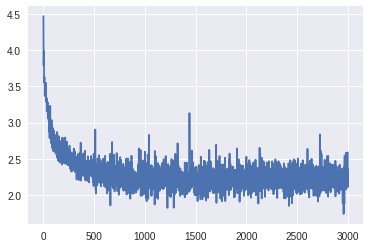

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [19]:
print(evaluate('Th', 200, temperature=0.8))

Thać wlesz, spoja zabanie ośliwa!
I sakon tak chwa siodo, w śroty,
Na jerz by oborać możnie marumarzał,
I cość by obacyś odwarze wimypa! mucze, bywa spymu mówi»
Da pryciącą wspodziona kusse
Obzyznie klu


Lower temperatures are less varied, choosing only the more probable outputs:

In [20]:
print(evaluate('Th', 200, temperature=0.2))

Tha się się się się w się się się piliwie się się się się się pięcie,
Jak się się w szy wielki się w się się panie,
Jak się podzieliwa wielkim się wielki mawanie zam pierwszy wiele wielka się się się si


Higher temperatures more varied, choosing less probable outputs:

In [23]:
print(evaluate('Th', 200, temperature=1.4))

Thńi! za tw cielon! (jękę --

Pyłachwi z trwoliejs, Phonia. łędzał niech, lezna.
Zrob- czlościDowy ożna, opryzknojąc wądły (chwiał, ma Bwe z u wzkołali ów elstki wszędzeszki, ożgęzył, hurgowę, bymałem  


# Exercises

* Train with your own dataset, e.g.
    * Text from another author
    * Blog posts
    * Code
* Increase number of layers and network size to get better results

**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)

# save model

In [ ]:
ALLCHARS, MODEL = ['all_characters', 'model']

fn_pan_tadeusz = {ALLCHARS: 'all_characters.pan_tadeusz.p', MODEL: 'pan_tadeusz.h400.l3.3000.gpu.torch'}

fn_dict = fn_pan_tadeusz

In [ ]:
# save all_characters
import pickle

pickle.dump(all_characters, open(tmp_path / fn_dict[ALLCHARS], 'wb'))

In [ ]:
# all_characters = pickle.load( open( tmp_path / fn_dict[ALLCHARS], 'rb' ) )
# n_characters = len(all_characters)

In [23]:
decoder.state_dict

<bound method Module.state_dict of RNN(
  (encoder): Embedding(89, 400)
  (gru): GRU(400, 400, num_layers=3)
  (decoder): Linear(in_features=400, out_features=89)
)>

In [26]:
# save model
model_path = tmp_path / fn_dict[MODEL]
torch.save(decoder, model_path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
# decoder = torch.load(model_path)